# Generating Data
Like in my post on [building neural networks from scratch](https://beckernick.github.io/neural-network-scratch/), I'm going to use simulated data. I can easily simulate separable data by sampling from a multivariate normal distribution.

In [1]:
import numpy as np
import nodepy 
import matplotlib.pyplot as plt
import sys
import scipy as sp
from scipy import io
%matplotlib inline

np.random.seed(12)
num_observations = 5
clusters = 1
dim = 5
spread = 1
margin = np.random.randint(10, size=dim) * 1

for i in range(clusters):
    if i == 0:
        x1 = np.random.multivariate_normal(np.random.randint(spread, size=dim) + margin, np.identity(dim), num_observations)
        x2 = np.random.multivariate_normal(np.random.randint(spread, size=dim), np.identity(dim), num_observations)
    else:
        x1 = np.append(x1, np.random.multivariate_normal(np.random.randint(spread, size=dim) + margin, np.identity(dim), num_observations), axis=0)
        x2 = np.append(x2, np.random.multivariate_normal(np.random.randint(spread, size=dim), np.identity(dim), num_observations), axis=0)

simulated_separableish_features = np.vstack((x1, x2)).astype(np.float32)
simulated_labels = np.hstack((np.zeros(len(x1)),
                              np.ones(len(x2))))
intercept = np.ones((simulated_separableish_features.shape[0], 1))
simulated_separableish_features = np.hstack((intercept, simulated_separableish_features))
dim += 1

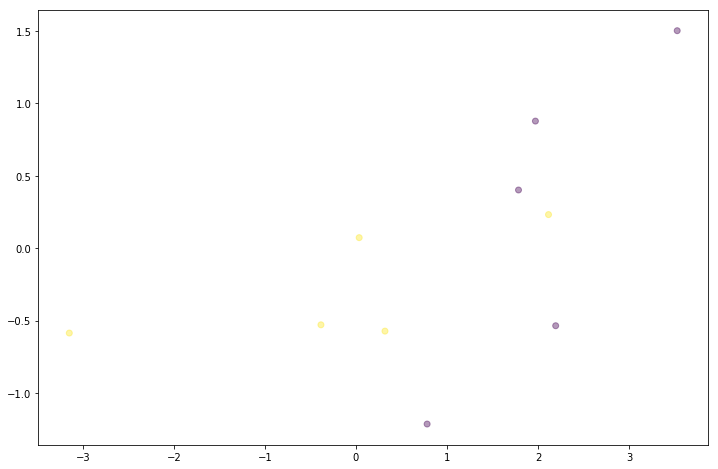

In [2]:
plt.figure(figsize=(12,8))
plt.scatter(simulated_separableish_features[:, -1], simulated_separableish_features[:, 2],
            c = simulated_labels, alpha = .4)

# Logistics

In [3]:
def sigmoid(scores):
    return 1 / (1 + np.exp(-scores))

In [4]:
def grad_logistic(X, Y, w):
    pred = sigmoid(np.dot(X, w))
    return np.dot(X.T, pred - Y)

def loss_logistic(X, Y, w):
    predictions = sigmoid(np.dot(X, w))
    epsilon = sys.float_info.min
    class1_cost = -Y*np.log(predictions + epsilon)
    class2_cost = (1-Y)*np.log(1-predictions + epsilon)
    return np.sum(class1_cost - class2_cost)


## Show that GD works

In [5]:
def gd(f, df, num_steps, learning_rate, inits, period=5000):
    losses = np.zeros(int(num_steps/period))
    weights = inits
    for step in range(num_steps):
        # Update weights with log likelihood gradient
        gradient = - df(weights)
        #gradient = np.dot(features.T, output_error_signal)
        weights += learning_rate * gradient
        # Print log-likelihood every so often
        if step % period == 0:
            losses[int(step/period)] = f(weights)
        if step % (num_steps/5) == 0:
            print(losses[int(step/period)])
        
    return weights, losses

In [6]:
weights = np.zeros(dim)
f = lambda x: loss_logistic(simulated_separableish_features, simulated_labels, x)
df = lambda x: grad_logistic(simulated_separableish_features, simulated_labels, x)
weights, losses = gd(f, df, num_steps = int(1e6), learning_rate = 1e-3, 
                     inits=weights, period=500)

6.522253947815998
0.005910451701913499
0.0029638207305222515
0.0019793140340678313
0.001486286825867946


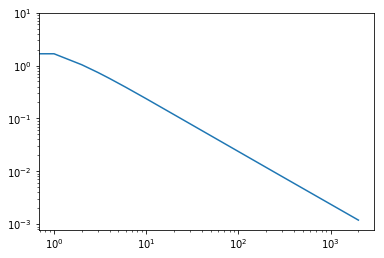

In [7]:
plt.loglog(losses[:])

In [8]:
print(losses[-1])

0.001190717202346841


In [9]:
def nag(f, df, num_steps, learning_rate, inits, period=5000):
    losses = np.zeros(int(num_steps/period))
    x = inits
    x_prev = inits
    y = inits
    for k in xrange(num_steps):
        # Update weights with log likelihood gradient
        x, x_prev = y - learning_rate * df(y), x
        y = x + (k-1.0)/(k+2.0)*(x-x_prev)

        # Print log-likelihood every so often
        if k % period == 0:
            losses[int(k/period)] = f(x)
        if k % (num_steps/10) == 0:
            print losses[int(k/period)]
        
    return x, losses

In [10]:
weights = np.zeros(dim)
f = lambda x: loss_logistic(simulated_separableish_features, simulated_labels, x)
df = lambda x: grad_logistic(simulated_separableish_features, simulated_labels, x)
weights, losses = nag(f, df, num_steps = int(1e6), learning_rate = 1e-3, 
                     inits=weights, period=500)

6.522253947815998
4.846267394868488e-07
1.2123436487060805e-07
5.389305325795998e-08
3.0318879330721896e-08
1.940612587715547e-08
1.3477666345157068e-08
9.902708890708635e-09
7.582260828342313e-09
5.991268153971403e-09


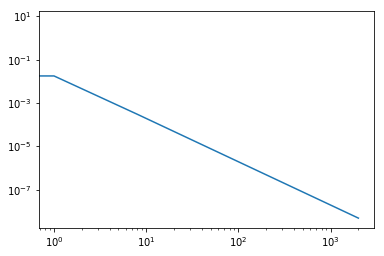

In [11]:
plt.loglog(losses[:])

# Simulate ODE flow

In [12]:

import nodepy.runge_kutta_method as rk
import nodepy.convergence as cv
from nodepy import ivp

class ODE_IVP(nodepy.ivp.IVP):
    
    def __init__(self, X, Y, p, u0, t0=0., T=1000000., desc='', name=''):
        
        #intercept = np.ones((X.shape[0], 1))
        #self.X = np.hstack((intercept, X))
        self.Y = Y
        self.X = X
        self.p = float(p)
        self.u0  = u0
        self.dim = len(u0)/2
        self.rhs = self.dynamics
        self.T   = T
        self.exact = None
        self.description = desc
        self.t0 = t0
        self.name = name
    
    def dynamics(self, t, u):
        x = u[:self.dim]
        v = u[self.dim:]
        p = self.p
        dv = - (p+1) / (t) * v - p**2 * t**(p-2) * grad_logistic(self.X, self.Y, x)
        return np.append(v, dv)
    
    

In [13]:
# Same integrator on different ODE

def simulate(p, s, N, period, step, inits):
    h = step
    if s==1:
        name = 'FE'
    elif s==2:
        name = 'SSP22'
    elif s==4:
        name = 'RK44'
    elif s==8:
        name = 'PD8'
    else:
        return None
    u = [inits]
    integrator =rk.loadRKM(name)
    loop = N/period
    losses = np.zeros(int(N/period))
    ode_ivp = ODE_IVP(simulated_separableish_features, simulated_labels, p, u0=u[-1])
    for j in range(loop):
        losses[j] = loss_logistic(simulated_separableish_features, simulated_labels, u[-1][:dim])
        t,u = integrator(ode_ivp, t0= 0.1 + j * period * h, dt=h, max_steps=period)
        ode_ivp = ODE_IVP(simulated_separableish_features, simulated_labels, p, u0=u[-1])
    return losses



In [14]:
## SHOW RGD WORKS

In [15]:
def rgd(f, df, num_steps, learning_rate, inits, period=5000):
    losses = np.zeros(int(num_steps/period))
    weights = inits
    for step in range(num_steps):
        # Update weights with log likelihood gradient
        gradient = - df(weights)
        #gradient = np.dot(features.T, output_error_signal)
        weights += learning_rate * gradient/(np.linalg.norm(gradient)+1e-14)
        # Print log-likelihood every so often
        if step % period == 0:
            losses[int(step/period)] = f(weights)
        if step % (num_steps/5) == 0:
            print(losses[int(step/period)])
        
    return weights, losses

In [16]:
N = int(1e6)
truncate = 0
period = 1
pvalues = [1,2,4]
nrange = period * np.arange(int(N/period)) - period + 1

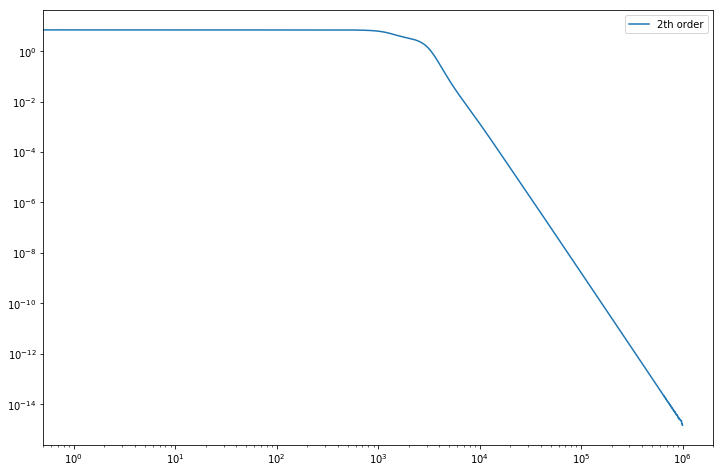

In [17]:
plt.figure(figsize = (12, 8))
losses = simulate(6, 2, N, period, 3e-4,np.zeros(dim * 2))
plt.loglog(nrange, losses[truncate:], label=str(2) + 'th order')
plt.legend()

6.522253947815998
0.005910451701913499
0.0029638207305222515
0.0019793140340678313
0.001486286825867946
6.522253947815998
4.846267394868488e-07
1.2123436487060805e-07
5.389305325795998e-08
3.0318879330721896e-08
1.940612587715547e-08
1.3477666345157068e-08
9.902708890708635e-09
7.582260828342313e-09
5.991268153971403e-09


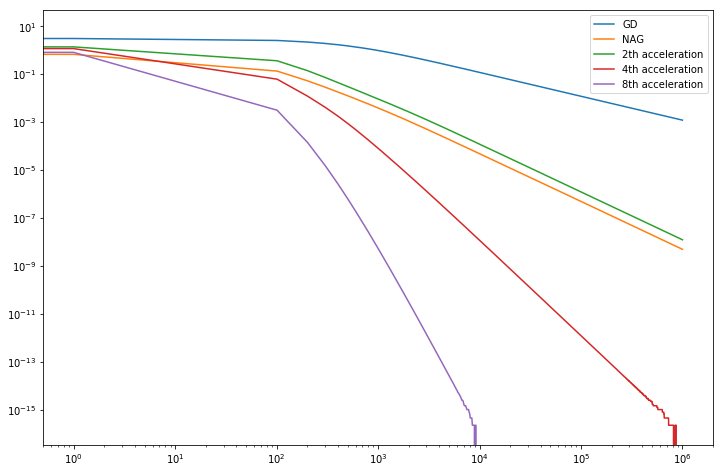

In [17]:
N = int(1e6)
truncate = 0
period = 1
pvalues = [1,2,4]
nrange = period * np.arange(int(N/period))- period + 1

svals = [4, 4, 8]
pvals = [2, 4, 8]
steps = [1e-2, 1e-2, 1e-2]
plt.figure(figsize = (12, 8))



f = lambda x: loss_logistic(simulated_separableish_features, simulated_labels, x)
df = lambda x: grad_logistic(simulated_separableish_features, simulated_labels, x)
weights = np.zeros(dim)
_, losses = gd(f, df, num_steps = N, learning_rate = 1e-3, 
                     inits=weights, period=period)
plt.loglog(nrange, losses[truncate:], label='GD')
weights = np.zeros(dim)
_, losses = nag(f, df, num_steps = N, learning_rate = 1e-3, 
                     inits=weights, period=period)
plt.loglog(nrange, losses[truncate:], label='NAG')


for i, s in enumerate(svals):
    losses = simulate(pvals[i], s, N, period, steps[i], np.zeros(dim * 2))
    plt.loglog(nrange, losses[truncate:], label=str(pvals[i]) + 'th acceleration')
plt.legend()
plt.rcParams.update({'font.size': 20})

6.522253947815998
0.005910451701913499
0.0029638207305222515
0.0019793140340678313
0.001486286825867946
0.001190125455597015
6.522253947815998
4.846267394868488e-07
1.2123436487060805e-07
5.389305325795998e-08
3.0318879330721896e-08
1.940612587715547e-08
1.3477666345157068e-08
9.902708890708635e-09
7.582260828342313e-09
5.991268153971403e-09
4.853184746716177e-09
6.003583887545208
0.0
0.0
0.0
0.0
0.0


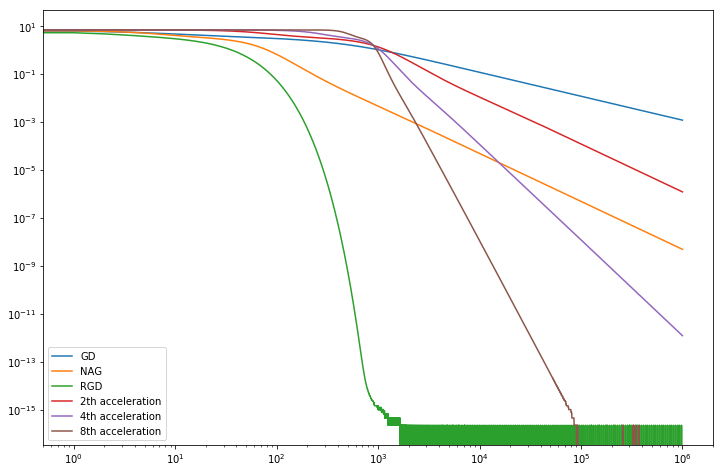

In [18]:
N = int(1e6)
truncate = 0
period = 1
pvalues = [1,2,4]
nrange = period * np.arange(int(N/period))- period + 1

svals = [2, 2, 2]
pvals = [2, 4, 8]
steps = [1e-3, 1e-3, 1e-3]
plt.figure(figsize = (12, 8))
loss_matrix = np.zeros((len(svals)+3, len(nrange)))



f = lambda x: loss_logistic(simulated_separableish_features, simulated_labels, x)
df = lambda x: grad_logistic(simulated_separableish_features, simulated_labels, x)
##gradient descent
weights = np.zeros(dim)
_, losses = gd(f, df, num_steps = N, learning_rate = 1e-3, 
                     inits=weights, period=period)
loss_matrix[0] = losses

print(losses[-1])
plt.loglog(nrange, losses[truncate:], label='GD')

##accelerated gradient descent
weights = np.zeros(dim)
_, losses = nag(f, df, num_steps = N, learning_rate = 1e-3, 
                     inits=weights, period=period)
loss_matrix[1] = losses
plt.loglog(nrange, losses[truncate:], label='NAG')
print(losses[-1])

##rescaled gradient descent
weights = np.zeros(dim)
_, losses = rgd(f, df, num_steps = N, learning_rate = 5e-2, 
                     inits=weights, period=period)
loss_matrix[2] = losses
plt.loglog(nrange, losses[truncate:], label='RGD')
print(losses[-1])

##Runge-kutta
weights = np.zeros(dim)


for i, s in enumerate(svals):
    losses = simulate(pvals[i], s, N, period, steps[i], np.zeros(dim * 2))
    loss_matrix[i+3] = losses
    plt.loglog(nrange, losses[truncate:], label=str(pvals[i]) + 'th acceleration')
plt.legend()
plt.rcParams.update({'font.size': 20})

In [19]:
sp.io.savemat('logistics.mat', {'loss_matrix': loss_matrix})

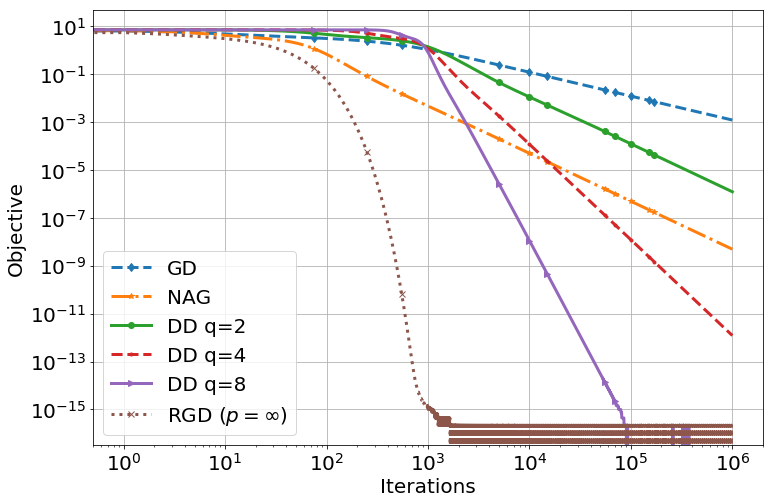

In [22]:
#plot_range = np.linspace(0,1e6,1000)
plt.figure(figsize = (12, 8))
plt.loglog(nrange, loss_matrix[0], label='GD', marker = 'd',markevery = [75,250,550,5000,10000,15000,55000,70000,100000,150000,170000], linestyle = 'dashed',linewidth=3)
plt.loglog(nrange, loss_matrix[1], label='NAG', marker = '*',markevery = [75,250,550,5000,10000,15000,55000,70000,100000,150000,170000], linestyle = '-.',linewidth=3)
#for i, s in enumerate(svals):
plt.loglog(nrange, loss_matrix[3], label='DD q=2', marker = 'o',markevery = [75,250,550,5000,10000,15000,55000,70000,100000,150000,170000],linewidth=3)
plt.loglog(nrange, loss_matrix[4], label='DD q=4', marker = '.',markevery = [75,250,550,5000,10000,15000,55000,70000,100000,150000,170000], linestyle = 'dashed',linewidth=3)
plt.loglog(nrange, loss_matrix[5], label='DD q=8', marker = '>',markevery = [75,250,550,5000,10000,15000,55000,70000,100000,150000,170000],linewidth=3)
plt.loglog(nrange, loss_matrix[2], label='RGD ($p=\infty$)', marker = 'x',markevery = [75,250,550,5000,10000,15000,55000,70000,100000,150000,170000], linestyle = ':',linewidth=3)



plt.legend()
plt.grid()
plt.xlabel('Iterations')
plt.ylabel('Objective')
plt.rcParams.update({'font.size': 20})

In [45]:
## GRADIENT EVALUATION COMPARISON

(1000000,)


(500000,)
[     1      2      3 ... 499998 499999 500000]


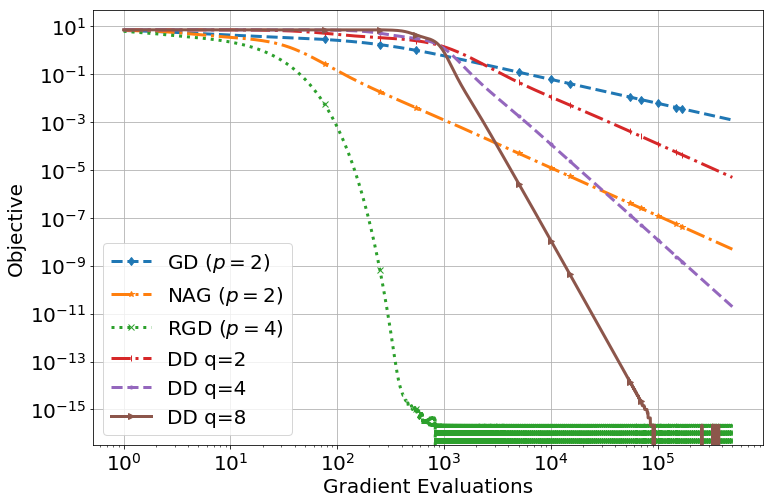

In [54]:
new_loss_matrix = np.zeros((len(svals)+3, len(nrange)/2))
for j in range(3):
    new_loss_matrix[j+3,:] = loss_matrix[j+3,0:len(nrange)/2]
for j in range(3):
    for i in range(len(nrange)/2):
        new_loss_matrix[j,i] = loss_matrix[j,2*i]

print((new_loss_matrix[0]).shape)
print(nrange[1:len(nrange)/2+1])
n = nrange[1:len(nrange)/2+1]
#plot_range = np.linspace(0,1e6,1000)
plt.figure(figsize = (12, 8))
plt.loglog(n, new_loss_matrix[0], label='GD ($p=2$)', marker = 'd',markevery = [75,250,550,5000,10000,15000,55000,70000,100000,150000,170000],linestyle = 'dashed',linewidth=3)
plt.loglog(n, new_loss_matrix[1], label='NAG ($p=2$)', marker = '*',markevery = [75,250,550,5000,10000,15000,55000,70000,100000,150000,170000],linestyle = '-.',linewidth=3)
plt.loglog(n, new_loss_matrix[2], label='RGD ($p=4$)', marker = 'x',markevery = [75,250,550,5000,10000,15000,55000,70000,100000,150000,170000], linestyle = ':',linewidth=3)
#plt.loglog(n, new_loss_matrix[3], label='ARGD ($p=4$)', marker = 'o',markevery = [75,250,550,5000,10000,15000,100000],linestyle = '-.',linewidth=3)


#for i, s in enumerate(svals):
plt.loglog(n, new_loss_matrix[3], label='DD q=2', marker = '|',markevery = [75,250,550,5000,10000,15000,55000,70000,100000,150000,170000],linestyle = '-.',linewidth=3)
plt.loglog(n, new_loss_matrix[4], label='DD q=4', marker = '.',markevery = [75,250,550,5000,10000,15000,55000,70000,100000,150000,170000],linestyle = 'dashed',linewidth=3)
plt.loglog(n, new_loss_matrix[5], label='DD q=8', marker = '>',markevery = [75,250,550,5000,10000,15000,55000,70000,100000,150000,170000],linewidth=3)


plt.legend()
plt.grid()
plt.xlabel('Gradient Evaluations')
plt.ylabel('Objective')
plt.rcParams.update({'font.size': 20})
